In [2]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_opening
from skimage.io import imread, imsave
from skimage import img_as_float32, img_as_ubyte
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.fftpack import fft

img = img_as_float32(imread('baseline.jpg', as_gray=True))

# imsave('skeleton.png', skeleton)


In [3]:
def skeletonize(Bb):
    skeleton = np.zeros_like(Bb, dtype=np.uint8)
    while Bb.max()>0:
        o = binary_opening(Bb)
        skeleton = skeleton | (Bb & 1-o)
        Bb = binary_erosion(Bb)
    return skeleton
Bb = (img > 0.2) * 1
skeleton=skeletonize(Bb)

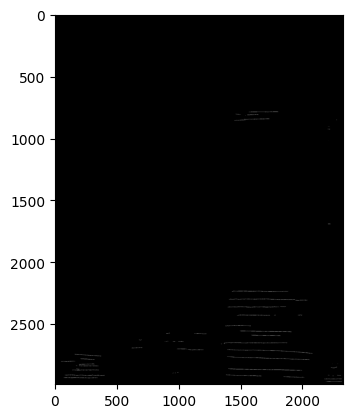

In [3]:
plt.imshow(skeleton, cmap='gray')

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_35136/1567029589.py:38: UserWarning: superpixels.png is a low contrast image
  imsave('superpixels.png', selected_mask)


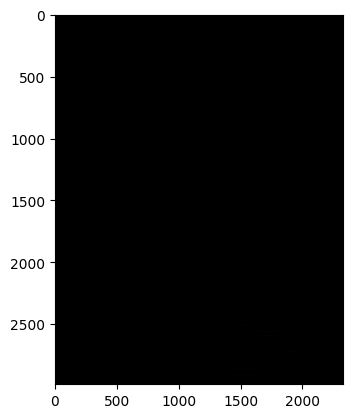

In [78]:
import cv2 
import time
from scipy.sparse import csr_matrix
from skimage import img_as_float

# baseline probs
baselines = np.copy(img)
baselines = img_as_float32(baselines)
sorted_intensity_indexes = np.argsort(baselines.ravel())[::-1]
selected_mask = np.zeros_like(skeleton, dtype=np.uint8)
superpixels = []
for i, index in enumerate(sorted_intensity_indexes):
    # Convert the flattened index to 2D indices
    i, j = np.unravel_index(index, baselines.shape)

    if not skeleton[i,j]:
        continue

    if baselines[i,j] < 0.2:
        break

    # Keeping number of superpixels small
    a = np.array((i,j))
    isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
    if isValid:
        selected_mask[i, j] = 255
        superpixels.append(a)

# print(selected_mask[selected_mask != 0])
plt.imshow(selected_mask, cmap='gray')
imsave('superpixels.png', selected_mask)

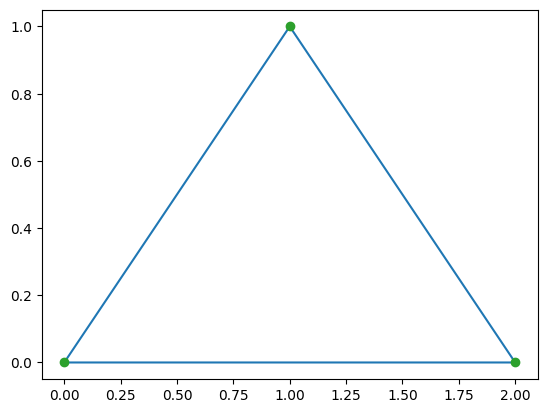

0
[2 1]


In [151]:
from scipy.spatial import Delaunay
from itertools import combinations


# Example set of point coordinates
points = np.array([[0, 0], [1, 1], [2, 0]])


# Compute the Delaunay triangulation
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

# Example point of interest

point_of_interest = points.tolist().index([0,0])
print(point_of_interest)

def find_neighbors(vertex_id, tri):
        pointer_to_vertex_neighbors, neighbors = tri.vertex_neighbor_vertices
        result_ids = neighbors[pointer_to_vertex_neighbors[vertex_id]:pointer_to_vertex_neighbors[vertex_id + 1]]
        return result_ids

print(find_neighbors(point_of_interest, tri))


In [4]:
def select_superpixels(B, Bs):
    '''
    Filter superpixels in the image.

    Parameters
    ----------
    B : array_like
       Baseline probability image
    Bs : array_like
       Skeletonized baseline image
    '''
    sorted_intensity_indexes = np.argsort(B.ravel())[::-1]
    superpixel_img = np.zeros_like(Bs, dtype=np.uint8)
    superpixels = []
    for index in sorted_intensity_indexes:
        # Convert the flattened index to 2D indices
        i, j = np.unravel_index(index, B.shape)

        if not Bs[i,j]:
            continue

        # If probability is worse than just a guess - pixel should not be part of baseline.
        # Further processing is not needed
        if B[i,j] < 0.2:
            break

        # mapping: i=y, j=x 
        a = np.array([i,j])
        # Keeping number of superpixels small
        isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
        if isValid:
            superpixel_img[i,j] = 255
            superpixels.append(a)
    return superpixels, superpixel_img

In [5]:
def compute_connectivity(e, I):
    '''
    Computes connectivity function - 
    the average intensity of image along the line segment `e`.

    Parameters
    ----------
    e : array_like
        e = (p, q), where p and q are arrays of coordinates of point p and q
    I : array_like
        Input image
    '''
    p, q = e

    segment_vector = np.array(q) - np.array(p)
    # Discretize the integral
    num_points = int(np.linalg.norm(segment_vector))
    intensity_sum = 0
    for t in range(num_points):
        point = np.round(p + t/num_points * segment_vector).astype(int)
        intensity_sum += I[point[0], point[1]]
    return intensity_sum/num_points

def get_point_neighbors(N, p):
    pointList = N.points.tolist()
    if not isinstance(p, list):
        p = list(p)
    p_index = pointList.index(p)
    pointer_to_vertex_neighbors, neighbors = N.vertex_neighbor_vertices
    neighbor_vertices = neighbors[pointer_to_vertex_neighbors[p_index]: \
                                  pointer_to_vertex_neighbors[p_index + 1]]
    nv_coords = [N.points[q] for q in neighbor_vertices]
    return nv_coords

def extract_lto(p, N, B):
    '''
    Extract local text orientation angle for each superpixel

    Parameters
    ----------
    p : list_like
        Superpixel coordinates
    T : object_like
        Delaunay tessellation object
    B : array_like
        The baseline prediction image B
    '''
    nv_coords = get_point_neighbors(N, p)
    M = [(np.array(p), q) for q in nv_coords]
    L = np.array([(e, compute_connectivity(e, B)) for e in M], dtype=object)
    # Sort by baseline connectivities.
    L = L[(-L[:,1]).argsort()]
    if len(L) == 1:
        e = L[0,0]
    else:
        # L[0,0] -> 0th neighbor of p (based on connectivity). Second index denotes
        # edge coordinate position. Next index (1) selects q or r coords that are not p.
        e = (L[0,0][1], L[1,0][1]) 
    return np.arctan(abs(e[1][0] - e[0][0])/(abs(e[1][1] - e[0][1])+ np.finfo(np.float64).eps))


In [6]:
def select_points_in_circle(a, points, radius):
    distances = np.linalg.norm(abs(points - a), axis=1)
    mask = distances <= radius
    points_within_circle = points[mask]
    return points_within_circle

def compute_projection_profile(points, angles, diameters):
    points = np.array(points)
    h_pd = []
    for id, p in enumerate(points):
        orientation_vector = np.array([np.cos(angles[id]), np.sin(angles[id])])
        h_d = []
        for dia in diameters:
            ps = select_points_in_circle(p, points, dia/2)
            pq = ps - p
            projections = np.dot(pq, orientation_vector)
            bin_indices = np.round(dia / 2 + projections).astype(int)
            counts = np.bincount(bin_indices, minlength=dia)
            h_d.append(np.array(counts))
        h_pd.append(np.array(h_d))
    return np.array(h_pd)


In [7]:
# Main code
B = img.copy()
Bb = (B > 0.2) * 1
print("running skeleton")
Bs = skeletonize(Bb)
print("running superpixels")
S, SI = select_superpixels(B, Bs)
print(len(S))
print("running delaunay")
N = Delaunay(S)
print("running lto")
angles = [extract_lto(p, N, B) for p in S]
ks = np.array([3,4,5])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)



running skeleton
running superpixels
745
running delaunay
running lto


/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1057/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


17


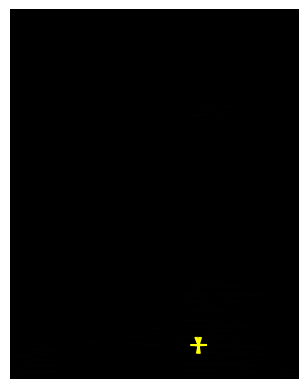

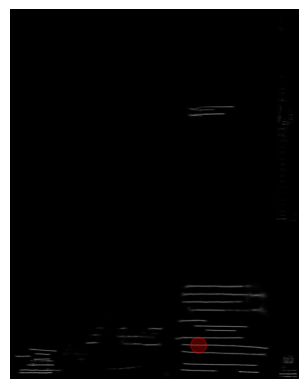

In [21]:
plt.imshow(SI, cmap='gray')
plt.axis("off")
p_idx = 300
x_S = S[p_idx][1]
y_S = S[p_idx][0]
q = select_points_in_circle(S[p_idx], np.array(S), 64)
print(len(q))
for i in range(len(q)):
    y_S2 = q[i][0]
    x_S2 = q[i][1]
    x = [x_S, x_S2]
    y = [y_S, y_S2]
    plt.plot(x,y, c='yellow')
fig, ax = plt.subplots()
ax.imshow(B, cmap='gray')
circle1 = plt.Circle((x_S, y_S), 64, color='r', alpha=.3)
ax.add_patch(circle1)
ax.axis('off')
plt.show()

In [680]:
# (point, (angle, random interline_distance))
states = [(p, (extract_lto(p, N, B), 64.0)) for p in S]

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_1057/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


(745, 4)


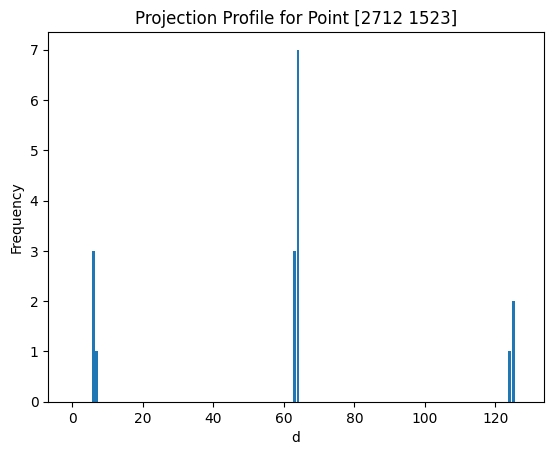

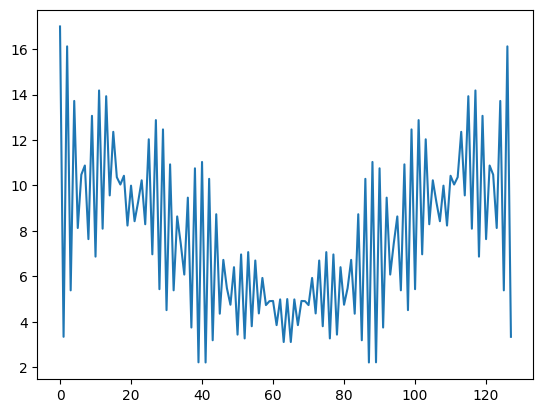

In [8]:
ks = np.array([3,4,5])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)
print(h.shape)
# fft_arr = fft(np.array(h, dtype=np.int64))
fft_arr = []
for p in range(len(S)):
    fft_d = []
    for d in range(len(ds)):
        fft_d.append(fft(h[p,d]))
    fft_arr.append(fft_d)

plt.bar(range(len(h[300,1])), h[300,1])
plt.xlabel('d')
plt.ylabel('Frequency')
plt.title('Projection Profile for Point {}'.format(S[300]))
plt.show()



H = fft_arr[300][1] #fft(h[300,1])
plt.plot(np.abs(H))
plt.show()


In [9]:
def compute_data_energies(H_pd, S):
    E_s_p = {}
    s_p_set = set()
    for p_id, p in enumerate(S):
        p = tuple(p)
        max_energy = 0
        energy_list = []
        for d_id in range(len(ds)):
            H_pd_dist_sq = np.sum(np.abs(H_pd[p_id][d_id])**2)
            for k_id in range(len(ks)):
                energy = np.abs(H_pd[p_id][d_id][k_id])**2/H_pd_dist_sq
                max_energy = max(energy, max_energy)
                s_p = round(ds[d_id]/ks[k_id])
                s_p_set.add(s_p)
                energy_list.append(energy)
        E_s_p[p] = dict(zip(s_p_set, energy_list))
    S_p_list = sorted(list(s_p_set), reverse=True)
    return S_p_list, E_s_p

# def gen_all_interline_distances(ds, ks):
#     S_d = []
#     for d in ds:
#         for k in ks:
#             S_d.append([d/k, d, k])
#     S_d = -np.sort(-np.array(S_d[:,0]))
#     S_d = S_d.tolist()
#     return S_d

S_p, E_p_s_p = compute_data_energies(fft_arr,S)
print(S_p)
print(E_p_s_p)

def get_max_energy_distance(p, E_pdk):
    p_idx = points.index(p)
    energy_config_map = E_pdk[p_idx]
    highest_energy_idx = np.argmax(energy_config_map.flatten())
    d, k = np.unravel_index(highest_energy_idx, energy_config_map.shape)
    return d/k, E_pdk[d, k]

def data_cost(p, s_p, alpha=1):
    point_dist_energy = E_p_s_p[p][s_p]
    cost =  alpha * (-np.log(point_dist_energy))
    return point_dist_energy

def get_pointlabel_mappings(dists, alpha, beta):
    label2graph = {}
    graph2label = {}
    graph_node = 0
    for p, (_, dist) in dists.items():
        if dist == alpha or dist == beta:
            graph2label[graph_node] = (p, dist)
            label2graph[p] = graph_node
            graph_node += 1
    return graph2label, label2graph

import maxflow as mf

def V_p_q(s_p, s_q, sigma=25):
    '''Definition of the potential'''
    index1 = S_p.index(s_p)
    index2 = S_p.index(s_q)
    dist = abs(index2 - index1)
    return dist if dist < 4 else sigma

def alpha_beta_swap_new(dists, alpha, beta, N):
    graph2label, label2graph = get_pointlabel_mappings(dists, alpha, beta)
    #extract position of alpha or beta interline distances
    graph_mf = mf.Graph[float](len(graph2label))
    nodes = graph_mf.add_nodes(len(graph2label))
    #add n-link edges
    weight = V_p_q(alpha, beta)
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        nv_nodes = get_point_neighbors(N, p)
        for nv_p in nv_nodes:
            nv_p_key = tuple(nv_p)
            if nv_p_key in label2graph:
                graph_mf.add_edge(i, label2graph[nv_p_key], weight, 0)
   
    #add all the terminal edges
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        #find neighbours
        nv_nodes = get_point_neighbors(N, p)
        fil_neigh = dict(filter(lambda el: np.any(np.all(np.array(nv_nodes) == el[0], axis=1)) 
                                and el[1][1] != alpha and el[1][1] != beta
                                , dists.items()))
        #consider only neighbours which are not having alpha or beta label
        # fil_neigh = dict(filter(lambda nv: nv[1][1] != alpha and nv[1][1] != beta, nv_dists.items()))
        # print(fil_neigh)
        #calculation of weight
        t_weight_alpha = np.sum([V_p_q(alpha,v[1]) for _,v in fil_neigh.items()]) + data_cost(p, alpha)
        t_weight_beta = np.sum([V_p_q(beta,v[1]) for _,v in fil_neigh.items()]) + data_cost(p, beta)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    #calculating flow
    graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(len(nodes))]
    # print(res)
    #depending on cut assign new label
    for i in range(len(res)):
        p, _ = graph2label[i] 
        (angle, _) = dists[p]
        if res[i] == 1:
            dists[p] = (angle, alpha)
        else:
            dists[p] = (angle, beta)
    
    return dists

def swap_minimization(dist_states, cycles=1):
    '''This methods implements the energy minimization via alpha-beta-swaps
       img_orig: is original input image
       img_work: optimized image
       cycles: how often to iterate over all labels'''
    T = 0
    import time
    import itertools
    key_combinations = itertools.combinations(S_p, 2)
    unique_pairs = set(key_combinations)
    #do iteration of all pairs a few times
    for u in range(0, cycles):
        #iterate over all pairs of labels 
        for pair in unique_pairs:
            start = np.round(time.time() * 1000)
            dist_states = alpha_beta_swap_new(dist_states, pair[0], pair[1], N)
            print('time', np.round(time.time()*1000) - start)
    return dist_states


[171, 128, 102, 85, 64, 51, 43, 32, 26, 21, 16, 13]
{(2935, 314): {32: 0.084375, 64: 0.026419950274766183, 128: 0.013241630502723837, 102: 0.0744047619047619, 43: 0.038322936293559484, 171: 0.02426344530317455, 13: 0.08551985062893082, 16: 0.030260639682024523, 51: 0.004648604953355909, 21: 0.09003311114958448, 85: 0.048729651114290944, 26: 0.004583278573009397}, (2935, 331): {32: 0.0625, 64: 0.020601178833192568, 128: 0.006906156166325105, 102: 0.06328125, 43: 0.041477288129319126, 171: 0.02393310966635891, 13: 0.07750496031746032, 16: 0.03023553801258754, 51: 0.0036116405172212734, 21: 0.09752926664086688, 85: 0.05293982997616446, 26: 0.005185401594665911}, (2944, 2295): {32: 0.0744485294117647, 64: 0.004674766441456427, 128: 0.013355239310873769, 102: 0.041051136363636366, 43: 0.017301679833908616, 171: 0.0025110508971761415, 13: 0.021814903846153845, 16: 0.009729726409655285, 51: 0.008502761524861582, 21: 0.011403093434343434, 85: 0.008651210536866181, 26: 0.004376191178447745}, (2

In [10]:
states = {tuple(p): (extract_lto(p, N, B), max(E_p_s_p[tuple(p)], key=E_p_s_p[tuple(p)].get)) for p in S}

In [11]:
new_states = swap_minimization(states)
print(len(new_states))
print(new_states)

time 5816.0
time 2521.0
time 0.0
time 1726.0
time 3213.0
time 1.0
time 999.0
time 615.0
time 788.0
time 37.0
time 2775.0
time 37.0
time 3390.0
time 373.0
time 442.0
time 2808.0
time 1726.0
time 1660.0
time 23.0
time 1751.0
time 2440.0
time 171.0
time 2792.0
time 222.0
time 281.0
time 2805.0
time 24.0
time 163.0
time 0.0
time 2761.0
time 37.0
time 162.0
time 2291.0
time 0.0
time 203.0
time 2255.0
time 3242.0
time 76.0
time 3260.0
time 71.0
time 3703.0
time 0.0
time 3536.0
time 0.0
time 0.0
time 79.0
time 3595.0
time 6755.0
time 2560.0
time 0.0
time 2339.0
time 242.0
time 247.0
time 115.0
time 5983.0
time 0.0
time 0.0
time 114.0
time 0.0
time 120.0
time 241.0
time 120.0
time 242.0
time 5953.0
time 0.0
time 0.0
745
{(2935, 314): (0.033320995878247196, 26), (2935, 331): (0.037020115873930025, 26), (2944, 2295): (0.0, 21), (2931, 1994): (0.0, 26), (2935, 202): (0.0, 21), (2936, 301): (0.03844259002118799, 26), (2936, 267): (0.0, 21), (2936, 288): (0.0, 21), (2936, 231): (0.03844259002118799

In [43]:
from scipy import misc
from imageio import imread
def load_img(path, scale, mode):
    aImg = imread(path)
    if scale != 1:
        sImg = np.array(Image.fromarray(aImg).resize())
        fImg = sImg
    else:
        fImg = aImg

    if len(fImg.shape) == 2:
        fImg = np.expand_dims(fImg,2)
    fImg = np.expand_dims(fImg,0)

    return fImg

In [73]:
from skimage import transform
from PIL import Image, ImageDraw
scale = 0.33
orig = Image.open('orig.jpg')
width, height = orig.size
new_size = (int(width * scale), int(height * scale))
resized_img = orig.resize(new_size)
img = ImageDraw.Draw(resized_img)  
for k, (angle_rad, pixels) in new_states.items():
    angle_rad, pixels= new_states[k]
    start_point = (k[0],k[1])
    angle = np.rad2deg(angle_rad) + 90
    angle_rad = np.deg2rad(angle)
    end_point = (int(start_point[0] - np.sin(angle_rad) * int(pixels)), int(start_point[1] + np.cos(angle_rad) * int(pixels)))
    img.line([(k[1], k[0]), (end_point[1], end_point[0]) ], fill ="red", width = 5)
resized_img.show()

In [77]:
print(N.)

In [103]:
x = np.array(S)[:,1]
y = np.array(S)[:,0]
t = np.array([x**i for i in range(3+1)]).T
print(y.shape)
print(np.linalg.inv(t).shape)
W = np.linalg.inv(t).dot(y)
print(y.shape)

(745,)


LinAlgError: Last 2 dimensions of the array must be square

In [78]:


# TODO:
# 1) Remove edges from N that are of different text orientations
# 2) Sort edges in N based on B-connectivity
# 3) Project SPs onto corresponding regression curve (regression of all points that were rotated by the mean angle)
# 4) Compute cluster distances
def build_edge_set(N, S, B):
    edge_set = {}
    for p in S.keys():
        neighbors = get_point_neighbors(N, p)
        for nv in neighbors:
            isSameOrientied = np.abs(S[p][0] - S[tuple(nv)][0]) % np.pi <= np.pi/4
            isValid = (p, tuple(nv)) not in edge_set and (tuple(nv), p) not in edge_set and isSameOrientied
            if isValid:
                e = (p, tuple(nv))
                edge_set[e] = compute_connectivity(e, B)
    return dict(sorted(edge_set.items(), key=lambda x: x[1], reverse=True))

def rotate(point, angle):
        cos_theta = np.cos(angle)
        sin_theta = np.sin(angle)
        rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
        return tuple(np.array(np.dot(rotation_matrix, point), dtype=int))

def cur(S, deg=3, return_params=False):
    '''
    Computes curvalinearity value. Additionally returns regression curve weights
    '''
    avg_angle = theta(S)
    S_prime = {rotate(k, -avg_angle): v for k, v in S.items()}
    y_prime, x_prime = np.array(list(zip(*S_prime)))
    print(x_prime)
    print(y_prime)
    # y, x = np.array(list(zip(*S)))
    X = np.array([x_prime**i for i in range(deg+1)]).T
    # Computing the left inverse of X (mxn), since in X we have that m > n:
    # (X^T @ X)^{-1} @ X^T
    X_inv = np.linalg.inv(X.T @ X) @ X.T
    W = X_inv.dot(y_prime)
    X = np.array([x_prime**i for i in range(deg+1)]).T
    y_pred = abs(np.array(X @ W, dtype=int))
    if return_params:
        return np.sqrt(np.mean((y_prime - y_pred)**2))/s(S), W, min(x_prime), max(x_prime)
    else:
        return np.sqrt(np.mean((y_prime - y_pred)**2))/s(S)

def compute_off_text_distance(p, q, angle):
    return np.abs((p[1]-q[1])*np.sin(angle) - (p[0]-q[0])*np.cos(angle))

import math

def curve(x, coeffs):
    a, b, c, d = coeffs
    return d*x**3 + c*x**2 + b*x + a

def get_projections(S):
    _, W, tmin, tmax = cur(S, return_params=True)
    coeffs = np.array(W.T)
    n = tmax-tmin
    t_vals = np.linspace(tmin, tmax, n)
    poly = np.array(np.round(curve(t_vals, coeffs)),dtype=int)
    rotated_points = [rotate((p,t), theta(S)) for p, t in zip(poly, t_vals)]
    angle = theta(S) + np.pi/2
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    projections = []
    for p in S.keys():
        min_dist = np.inf
        projection_idx = 0
        for idx, rp in enumerate(rotated_points):
            dist = np.abs(cos_angle * (p[0] - rp[0]) - sin_angle * (p[1] - rp[1]))
            if dist < min_dist:
                projection_idx = idx
                min_dist = dist
        projections.append(rotated_points[projection_idx])
    projected_states = {}
    for i in range(len(projections)):
        if i == len(projections)-1:
            y0, x0 = projections[i-1]
            y1, x1 = projections[i]
        else:
            y0, x0 = projections[i]
            y1, x1 = projections[i+1]
        angle = np.arctan(abs(y1 - y0) / abs(x1-x0))
        projected_states[projections[i]] = (angle, 0)
    return projected_states

def L2_norm(p, q):
    return np.sqrt((q[1] - p[1])**2 + (q[0] - p[0])**2)

def cluster_distance(S1, S2):
    Sc_1 = get_projections(S1)
    Sc_2 = get_projections(S2)
    distances = []
    for p in Sc_1.items():
        for q in Sc_2.items():
            union = p.update(q)
            if L2_norm(p[0], q[0]) < 4 * s(union):
                avg_angle = theta(union)
                distances.append(compute_off_text_distance(p[0], q[0], avg_angle))
    return min(distances)

def build_edge_set(N, S, B):
    edge_set = {}
    for p in S.keys():
        neighbors = get_point_neighbors(N, p)
        for nv in neighbors:
            isSameOrientied = np.abs(S[p][0] - S[tuple(nv)][0]) % np.pi <= np.pi/4
            isValid = (p, tuple(nv)) not in edge_set and (tuple(nv), p) not in edge_set and isSameOrientied
            if isValid:
                e = (p, tuple(nv))
                edge_set[e] = compute_connectivity(e, B)
    return dict(sorted(edge_set.items(), key=lambda x: x[1], reverse=True))


def find_cluster_index(p, q, P_star):
    pass

def remove_edge(p, q, N):
    pass

def remove_cluster(Sx, S):
    '''
    Remove cluster Sx from S
    '''
    pass

def theta(S):
    '''
    Computes average angle
    '''
    return np.mean([v[0] for _,v in S.items()])


def s(S):
    '''
    Computes average interline distance
    '''
    return np.mean([v[1] for _,v in S.items()])


def merge_clusters(p, i, P_star, S0, N, gamma, delta):
    '''
    Merge point p into cluster Si
    '''
    if cur(P_star[i]+ [p]) < gamma \
        and cluster_distance(P_star[i], [p]) < delta * theta(P_star[i]):
        Sj = [P_star[j] for j in range(len(P_star)) if j > 0 and j != i]
        if cluster_distance(P_star[i] + [p], Sj) > delta * theta(Sj):
            N = remove_edge(p, q, N)
            P_star[i] = P_star[i] + [p]
            S0 = remove_cluster([p], S0)
    return S0, N

def cluster_sp(S, N, states, delta = 1, gamma = 1):
    S0 = S.copy()
    P_star = []
    n = 0
    while len(N) != n:
        n = len(N)
        for (p, q) in N:
            p_idx = find_cluster_index(p, P_star)
            q_idx = find_cluster_index(q, P_star)
            if p_idx > 0 and p_idx == q_idx:
                # Already in some cluster
                N = remove_edge(p, q, N)
            elif p_idx == 0 and q_idx == 0:
                # Create a new cluster
                avg_angle = np.average([states[tuple(p)], states[tuple(q)]])
                if compute_off_text_distance(p, q, avg_angle) < delta * theta([p,q]):
                    N = remove_edge(p, q, N)
                    Snew = [p, q]
                    P_star.append(Snew)
                    S0 = remove_cluster(Snew, S0)
            elif p_idx == 0 and q_idx > 0:
                # Attempt to merge point p from clutter cluster into cluster with q
                S0, N = merge_clusters(p, q_idx, P_star, S0, N, gamma, delta)
            elif q_idx == 0 and p_idx > 0:
                # Attempt to merge point q from clutter cluster into cluster with p
                S0, N = merge_clusters(q, p_idx, P_star, S0, N, gamma, delta)
            elif p_idx != q_idx and (p_idx > 0 and q_idx > 0):
                # Attempt to merge p and q neighboring clusters
                validMerge = cur(P_star[p_idx] + P_star[q_idx]) < gamma \
                         and cluster_distance(P_star[p_idx], P_star[q_idx]) < delta * min(theta(P_star[p_idx]), \
                                                                                          theta(P_star[q_idx]))
                if validMerge:
                    N = remove_edge(p, q, N)
                    P_star[p_idx] = P_star[p_idx] + P_star[q_idx]
                    P_star = remove_cluster(P_star[q_idx], P_star)
    return P_star

In [81]:
key1 = (2935, 314)
key2 = (2935, 331)
key3 = (2936, 301)
key4 = (2936, 288)
S1 = {key1: new_states[key1], key2: new_states[key2], key3: new_states[key3], key4: new_states[key4]} 
# S2 = {}
cur(S1)
# cluster_distance(S1, S2)

[234 251 221 208]
[2942 2942 2943 2942]


0.04040404040404041

In [116]:
import math

def curve(x, coeffs):
    a, b, c, d = coeffs
    return d*x**3 + c*x**2 + b*x + a

def compute_projection(S):
    _, W, tmin, tmax = cur(S, return_params=True)
    coeffs = np.array(W.T)
    n = tmax-tmin
    t_vals = np.linspace(tmin, tmax, n)
    poly = np.array(np.round(curve(t_vals, coeffs)),dtype=int)
    rotated_points = [rotate((p,t), theta(S)) for p, t in zip(poly, t_vals)]
    angle = theta(S) + np.pi/2
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    projections = []
    for p in S.keys():
        min_dist = np.inf
        projection_idx = 0
        for idx, rp in enumerate(rotated_points):
            dist = np.abs(cos_angle * (p[0] - rp[0]) - sin_angle * (p[1] - rp[1]))
            if dist < min_dist:
                projection_idx = idx
                min_dist = dist
        projections.append(rotated_points[projection_idx])
    return projections
compute_projection(S1)

[234 251 221 208]
[2942 2942 2943 2942]
(2934, 314)


[(2934, 314), (2934, 330), (2935, 301), (2935, 288)]

t
test
[234 251 221 208]
[2942 2942 2943 2942]
0.04040404040404041
208
251
[ 5.32399645e+02  3.14820542e+01 -1.36686399e-01  1.97238670e-04]
3
288 2936
